단어 -> 임베딩(embedding space) -> RNN -> context vector

## Embedding이란?

: 단어를 숫자로 바꾸는 것. 단순한 숫자로 바뀌는 것이 아니라, "의미를 가진 벡터"로 바꾸는 것

ex)

"나는"   / 임베딩 벡터 : [0.2,0.4]

"학교에" / 임베딩 벡터 : [0.7,0.1]

"간다" / 임베딩 벡터 : [0.9,0.3]

이렇게 단어 하나를 2차원 공간에 표현 하는 것.
이 공간이 임베딩 공간(embedding space)라고 함.

Context vector

여러 단어가 있는 문장에서 핵심 의미를 요약한 벡터

In [ ]:
import numpy as np

#1. 단어를 숫자로 표현

word_to_index = {'<pad>' : 0, '나는':1,'학교에':2,'간다':3}
sentence = ['나는','학교에', '간다']
word_indices = [word_to_index[word] for word in sentence] #1,2,3

print('단어 인덱스 : ', word_indices)

# 2. 임베딩 공간으로 변환
vocab_size = len(word_to_index) #4개
embedding_size = 2 #각 단어를 2차원 벡터로 변환

#(vocab_size, embedding_dim) :임베딩 행렬
embedding_matrix = np.array([
    [0.0, 0.0], #<pad>
    [0.1, 0.3], #나는
    [0.7, 0.2], #학교에
    [0.6, 0.9] #간다
])

#인덱스를 임베딩으로 바꾸기
embedded = embedding_matrix[word_indices] #(3,2)
print('임베딩된 단어 벡터')
print(embedded)

단어 인덱스 :  [1, 2, 3]
임베딩된 단어 벡터
[[0.1 0.3]
 [0.7 0.2]
 [0.6 0.9]]


In [ ]:
#3.RNN처럼 하나씩 순서대로 처리

#hidden state를 초기화
hidden_dim = 2
h_t = np.zeros(hidden_dim)

#RNN 가중치 초기화(랜덤 혹은 고정)
W = np.array([[0.5,0.4],[0.3,0.8]]) #(hidden_dim, embedding_dim)
U = np.array([[0.1, 0.2], [0.7, 0.6]]) # (hidden_dim, hidden_dim)
b = np.array([0.05,0.1]) #(hidden_dim)

hidden_state = []

# RNN 계산 :  h_t = tanh(W*x_t+U*h_{t-1}+b)
for x_t in embedded:
    h_t = np.tanh(np.dot(W,x_t)+np.dot(U,h_t)+b)
    hidden_state.append(h_t)
hidden_state = np.stack(hidden_state) #(3,2)
print('RNN hidden state (각 단어의 의미 처리 결과)')
print(hidden_state)

RNN hidden state (각 단어의 의미 처리 결과)
[[0.21651806 0.35399171]
 [0.51715641 0.68259537]
 [0.71543723 0.94378088]]


In [ ]:
#4. Attention으로 Context vector를 계산.

# 여기서, 마지막 hidden을 기준으로 중요도를 판단한다고 가정.
query = hidden_state[-1] #마지막 단어 기준

# 각 hidden과 query의 유사도(점수)를 dot-product로 계산
scores = np.dot(hidden_state,query) #(3,)

#softmax
exp_scores = np.exp(scores-np.max(scores)) #overflow 방지.
attention_weights = exp_scores / np.sum(exp_scores)

#가중합 = context vector
context_vector = np.sum(hidden_state * attention_weights[:,np.newaxis],axis=0)

print('Attention의 가중치 (각 단어의 중요도)')
print(attention_weights)

print('Context vector(전체 의미 요약) : ')
print(context_vector)

Attention의 가중치 (각 단어의 중요도)
[0.1928993  0.32615933 0.48094137]
Context vector(전체 의미 요약) : 
[0.55452493 0.74482287]


Python 시각화 코드(Context Vector 흐름)

In [ ]:
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
fonts-nanum is already the newest version (20200506-1).
0 upgraded, 0 newly installed, 0 to remove and 30 not upgraded.
/usr/share/fonts: caching, new cache contents: 0 fonts, 1 dirs
/usr/share/fonts/truetype: caching, new cache contents: 0 fonts, 3 dirs
/usr/share/fonts/truetype/humor-sans: caching, new cache contents: 1 fonts, 0 dirs
/usr/share/fonts/truetype/liberation: caching, new cache contents: 16 fonts, 0 dirs
/usr/share/fonts/truetype/nanum: caching, new cache contents: 12 fonts, 0 dirs
/usr/local/share/fonts: caching, new cache contents: 0 fonts, 0 dirs
/root/.local/share/fonts: skipping, no such directory
/root/.fonts: skipping, no such directory
/usr/share/fonts/truetype: skipping, looped directory detected
/usr/share/fonts/truetype/humor-sans: skipping, looped directory detected
/usr/share/fonts/truetype/liberation: skipping, looped directory detected
/usr/share/fonts/truetype/

In [ ]:
import matplotlib.pyplot as plt

plt.rc('font', family='NanumBarunGothic')

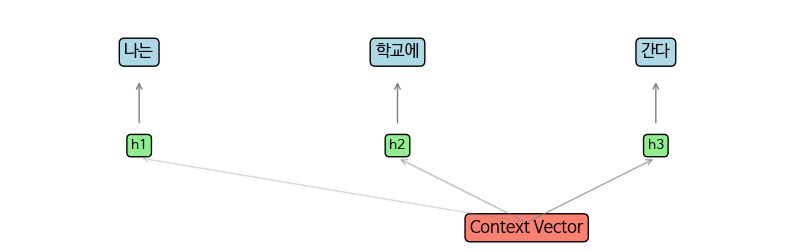

In [ ]:
import matplotlib.pyplot as plt

def darw_context_vector_diagram():
    fig,ax = plt.subplots(figsize=(10,3))
    ax.axis('off') #축 숨기기

    #1. 입력 단어(텍스트 박스로 표시)
    words = ['나는','학교에','간다']
    for i,word in enumerate(words):
        ax.text(i*2, 2, word, fontsize=12,ha='center',bbox=dict(boxstyle="round",
                                                                fc='lightblue'))
    #2. 각 단어의 RNN hidden state
    for i in range(len(words)):
        ax.text(i*2,1,f"h{i+1}", fontsize=10, ha='center',
                bbox=dict(boxstyle="round",fc='lightgreen'))
        #화살표 : 단어 -> hidden state
        ax.annotate('',xy=(i*2, 1.75), xytext=(i*2,1.25)
        ,arrowprops=dict(arrowstyle='->', color='gray'))
    #3. Context vector
    ax.text(3,0.1,"Context Vector", fontsize=12,ha='center',
            bbox = dict(boxstyle="round", fc="salmon"))

    #화살표 : 각 hidden state -> context vector(attention)
    for i in range(len(words)):
        ax.annotate('', xy=(i*2, 0.9), xytext=(3,0.2),
                    arrowprops=dict(arrowstyle='->',color='gray',alpha=0.3+0.2*i))
    #범위 설정
    ax.set_xlim(-1,5)
    ax.set_ylim(0,2.5)

    plt.show()
darw_context_vector_diagram()

## Self-Attention 핵습 구조 학습

$\hspace{5cm}Attention(Q,K,V) = softmax( {\frac{QK^T}{\sqrt{d_k}}}) V $

In [9]:
import numpy as np

#1. 입력 :  3단어 문장(인덱스 시퀀스)
vocab_size=5
embedding_dim=4
sequence_len = 3
hidden_dim = 4 # Q,K,V 차원

#단어 인덱스 ex) 나는 학교에 간다.->[1,2,3]
input_ids = np.array([1,2,3])

#2. 임베딩 행렬(vocab_sizeXembedding)
np.random.seed(42)
embedding_matrix = np.random.rand(vocab_size, embedding_dim)

# print(embedding_matrix)
# 3. 입력을 임베딩 벡터로 변환.
embedded_input = embedding_matrix[input_ids] #shape : (seq_len, embedding_dim)

print(embedded_input)

#4.Wq,wk,wv 정의 (각각 선형 변환 행렬)
w_q = np.random.rand(embedding_dim, hidden_dim)
w_k = np.random.rand(embedding_dim, hidden_dim)
w_v = np.random.rand(embedding_dim, hidden_dim)

#5. Q,K,V 계산
Q = embedded_input@ w_q #(seq_len, hidden_dim) / @ : 행렬곱
#임베딩된 단어 벡터를 Query로 변환.
K = embedded_input@ w_k
#임베딩된 단어 벡터를 Key로 변환.
V = embedded_input@ w_v
#임베딩된 단어 벡터를 Value로 변환.

#6.Attention Score 계산 : (QK^T) / (sqrt(d_k))
# Attenion Score를 통해 각 단어가 다른 단어에 얼마나 중요하게 생각할지에 대한 부분
dk = Q.shape[-1] #dk는 Query의 shape
# Query의 shape : [seq_len, d_k] / (batch,seq_len,d_k)
# Q.shape[-1] -> Query의 벡터의 차원의 수.
scores = Q @K.T / np.sqrt(dk) #shape : (seq_len, seq_len)
#길이가 길어지면, 비교할게 많아짐 -> 시간이 오래걸리게 됨.
#->embedding을 구성을 어떻게 하느냐에 따라 달라짐.

#shape : (seq_len, seq_len) -> sum(axis=1 or axis=-1)
# 각 Query별(행)로 softmax를 적용해야 하므로 axis=1이거나 axis=-1을 해야함.

def softmax(x):
    e_x = np.exp(x-np.max(x,axis=-1,keepdims=True))
    return e_x / np.sum(e_x,axis=-1, keepdims=True)
#softmax : 입력된 숫자 벡터를 전체 합이 1이 되도록 정규화해서 각 값이
# 상대적인 "확률"처럼 해석해주는 함수.

attention_weights = softmax(scores) #shape : (seq_len,seq_len)

#8. Context_vector = Attention weight *V
context = attention_weights @ V #shape: (seq_len, hidden_dim)

print('Attention Weights : ', attention_weights)
print('Context Vectors : ', context)

[[0.15601864 0.15599452 0.05808361 0.86617615]
 [0.60111501 0.70807258 0.02058449 0.96990985]
 [0.83244264 0.21233911 0.18182497 0.18340451]]
Attention Weights :  [[0.25617306 0.5158894  0.22793754]
 [0.20440214 0.62661422 0.16898364]
 [0.28161861 0.46732269 0.2510587 ]]
Context Vectors :  [[0.78797711 1.00477299 0.50643005 1.28204384]
 [0.81201468 1.04949018 0.51247246 1.34694102]
 [0.77607371 0.98439413 0.50264825 1.25319959]]


$softmax(x_i) = {\frac {e^{x_{j} }} { {\sum_j}{e^{x_j}}}}  $

In [3]:
#axis=-1 #1차원 일때,
x = np.array([3.0,1.0,0.2])

np.sum(x,axis=-1)

np.float64(4.2)

In [4]:
#axis=-1 #2차원 일때,

x = np.array([
    [3.0,1.0,0.2],
    [2.0,4.0,1.0]
])
np.sum(x,axis=-1) #행으로 작동.

array([4.2, 7. ])

In [6]:
#오버플로우 : 넘쳐흐른다. -> 수치 값이 표현할 수 있는 최대값을 초과했을때
x = [1000,1001,1002]
np.exp(x) #infimum -> 무한대. exp = 2.714xxxx
np.exp(x - np.max(x))

<ipython-input-6-a0644e6709ae>:3: RuntimeWarning: overflow encountered in exp
  np.exp(x) #infimum -> 무한대. exp = 2.714xxxx


array([0.13533528, 0.36787944, 1.        ])

In [8]:
import sys
print(sys.float_info.max) #최대값이 약 1.79X10^(308)

1.7976931348623157e+308
